<div align="right"><h8><i>Cristina Cristalli - 838022<br>
Francesca Franzese - 847780<br>
    Alessia Petescia - 839141</i><br><br>
    <b>Progetto Digital Signal and Image Management - Punto 3<br>
        CdL Data Science 2020</b></h8></div>

## 3. Retrieval

<b>Task: </b> trovare all'interno del dataset fornito i 10 volti più somiglianti a quelli dei membri del gruppo.
<br>
<br>Il notebook è strutturato come segue:
<ol>
    <li><i>Selezione delle immagini: </i>Data l'elevata dimensionalità del dataset, si è deciso di selezionare 5 immagini per ciascun personaggio come segue:

<ul style="list-style-type:square">
<li> Le immagini sono state ordinate per size, così da considerare le più informative (in termini di weight/height e/o resolution)</li>
<li>E' stato implementato un face detector con l'utilizzo di Open CV</li>
<li>La qualità delle immagini estratte è stata valutata attraverso l'uso combinato delle funzioni Canny e HoughLinesP di OpenCV </li>
<li>Solo le immagini di elevata qualità sono state mantenute</li>
</ul>

</li>
<br>
<li><i>Estrazione delle features: </i>Sono estratte le features convoluzionali utilizzando il modello pre-addestrato VGG16 come feature extractor</li>
<br>
<li><i>Costruzione degli alberi di ricerca: </i> Le features estratte sono utilizzate per costruire gli alberi di ricerca, in particolare:

<ul style="list-style-type:square">
<li>KDtree</li>
<li>BallTree</li>
</ul>
<br>
<li><i>Interrogazione degli alberi di ricerca: </i> i risultati sono restituiti per similarità decrescente</li>
</ol>

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import cv2
import random
import PIL
from PIL import Image
from os import listdir
from matplotlib import image
from matplotlib import pyplot as plt
import seaborn as sns
from time import time
import joblib

from sklearn.neighbors import KDTree, BallTree

import tensorflow
import keras
from keras.preprocessing import image as kimage
from keras.utils import np_utils
from keras.models import Sequential , Model
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img,img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D , Input, ReLU, Softmax
from keras_vggface.vggface import VGGFace
from keras.applications.vgg16 import preprocess_input
from keras.engine import  Model
from keras.layers import Input

import mtcnn
from mtcnn.mtcnn import MTCNN


Using TensorFlow backend.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

<h2>Face Detection</h2>

In [ ]:
detector = MTCNN()

In [ ]:
def facedetector(img,nome):
    try:
        required_size=(224, 224)
        pixels = cv2.imread(img)       
        results = detector.detect_faces(pixels)

        # estrazione della bounding box
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height

        # estrazione della faccia
        face = pixels[y1:y2, x1:x2]

        # resize dei pixels alla size standard
        image = Image.fromarray(face)
        image = image.resize(required_size)
        
        # conversione dell'immagine in un array
        vip_array = asarray(image)    
        
        # Controllo della qualità della foto dopo le operazioni appena eseguite
        # Se la foto risulta essere troppo "pixelata", viene eliminata
        gray = cv2.cvtColor(vip_array, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)        
        lines = cv2.HoughLinesP(edges,1,np.pi/180,100,200,10)        
        
        if lines:         
            return 0
        
        else:
            # Salvataggio delle foto in una cartella in locale, così da permettere il reload più veloce
            directory='C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/box_puntotre'
            os.chdir(directory)
            cv2.imwrite(nome, vip_array)
        
    except:
        return 0
   
    return 1

In [ ]:
conta=0
link = 'C:/Users/Francesca Franzese/Desktop/Digital Signal and Image Management/Progetto/thumbnails_features_deduped_publish'

for fi, filename in enumerate(sorted(os.listdir(link))):
    conta=0
    # Ordinamento delle foto in base alla loro size
    foto_ordinate = os.listdir(link +'/' + filename)
    foto_ordinate.sort(key=lambda f: os.stat(link +'/' + filename+'/' +f).st_size, reverse=True)
    
    for elem in foto_ordinate:        
        if elem.endswith('.jpg'):              
            #per ogni vip, vengono salvate al massimo 5 foto
            if conta<5:
                nome=filename+"_"+ elem
                sol = facedetector(link +'/' + filename+"/" + elem,nome)
                if sol == 1:
                    conta+=1

<h2>Caricamento delle immagini e calcolo delle features</h2>

In [2]:
# Feature dummy
def identity(image):
    return image

# Data loader
def load_data(feature_extractor=identity):
    base_path = './box_puntotre/'

    paths = []
    features = []
    contatore = 0

    for fi,f in enumerate(sorted(os.listdir(base_path))):
        #contatore per monitorare lo status del caricamento
        if contatore % 500 == 0:
            print (contatore)
        
        if f.endswith('.jpg'):
            # Memorizza percorso file
            cur_path = base_path + f 
            paths.append(cur_path)

            # Carica file ed estraine le features
            image = kimage.load_img(cur_path, target_size=(224, 224))
            cur_features = feature_extractor(image)
            features.append(cur_features)
        contatore = contatore+1
                
    features = np.array(features)
    return features, paths

In [3]:
vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [4]:
def neural_features(img):
    x = kimage.img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    f = vgg_features.predict(x)
    return f.flatten()

In [5]:
#caricamento delle immagini e calcolo delle features
t0 = time()
immmagini_vip, paths = load_data(feature_extractor=neural_features)
print("Caricamento e feature extraction in %0.3f secondi" % (time() - t0))

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
Caricamento e feature extraction in 2570.473 secondi


In [6]:
#numero immagini 
len(immmagini_vip) 

5744

<h2>Alberi di ricerca</h2>

In [7]:
#costruisco il KDtree
kd_tree = KDTree(immmagini_vip)

In [9]:
#costruisco il ball tree
ball_tree = BallTree(immmagini_vip)

In [10]:
# Salvataggio alberi di ricerca
joblib.dump(kd_tree, 'KDtree.joblib')
joblib.dump(ball_tree, 'BallTree.joblib')

['BallTree.joblib']

In [ ]:
# Caricamento alberi di ricerca
kd_tree = joblib.load('KDtree.joblib')
ball_tree = joblib.load('BallTree.joblib')

<h2>Query</h2>

In [11]:
# Caricamento delle immagini per le query, già modificate dal facedetector (punto 2 del progetto)
image_fra = kimage.load_img('box_fra/2_0.jpg', target_size=(224, 224)) 
image_cri = kimage.load_img('box_cri/1_0.jpg', target_size=(224, 224))
image_ale = kimage.load_img('box_ale/0_1.jpg', target_size=(224, 224))


In [12]:
# Calcolo features
image_fra_features = neural_features(image_fra)
image_cri_features = neural_features(image_cri)
image_ale_features = neural_features(image_ale)

image_fra_features.shape
image_cri_features.shape
image_ale_features.shape

(512,)

In [13]:
# Aggiunta dimensione per l'uso del KDTree
image_fra_features = np.expand_dims(image_fra_features, axis=0)
image_fra_features.shape

image_cri_features = np.expand_dims(image_cri_features, axis=0)
image_cri_features.shape

image_ale_features = np.expand_dims(image_ale_features, axis=0)
image_ale_features.shape

(1, 512)

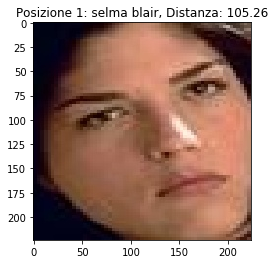

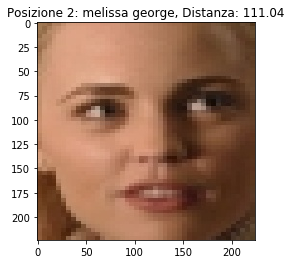

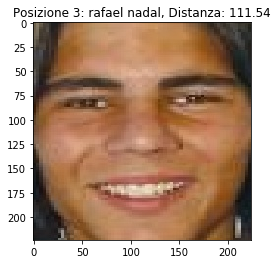

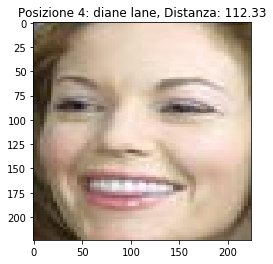

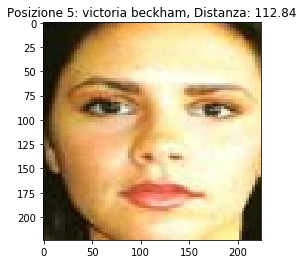

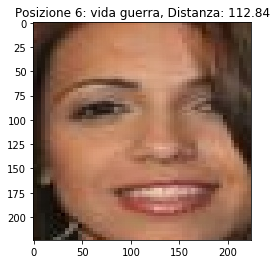

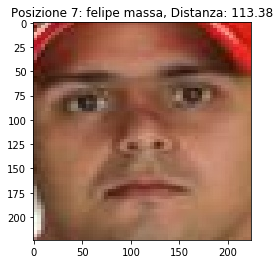

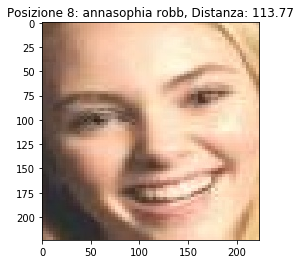

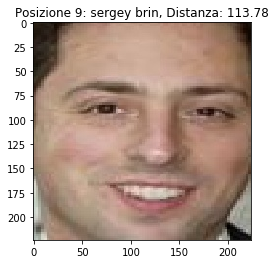

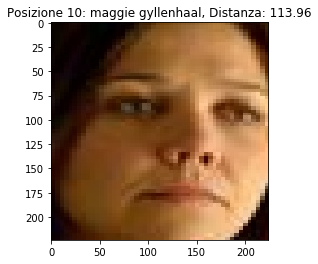

In [78]:
#FRA CON KDTREE

# Ricerca
dist_fra_kd, ind_fra_kd = kd_tree.query(image_fra_features, k=10)

# print
for x in range(0,10):
    titolo = 'Posizione ' + str(x+1) + ': ' + str(paths[ind_fra_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distanza: ' + str(round(dist_fra_kd[0][x], 2)) 
    
    temp = kimage.load_img(paths[ind_fra_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(titolo)
    

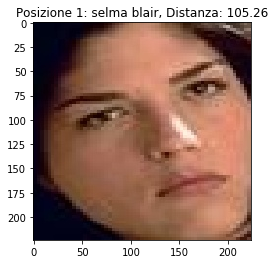

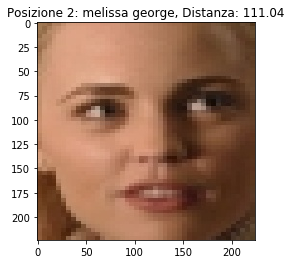

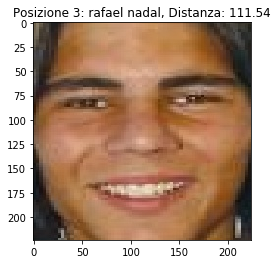

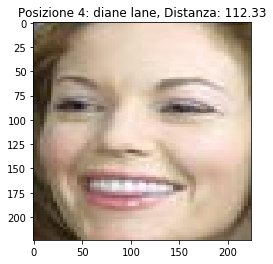

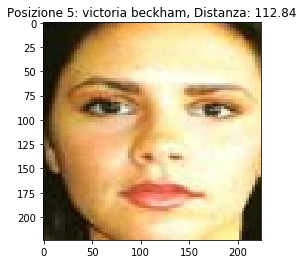

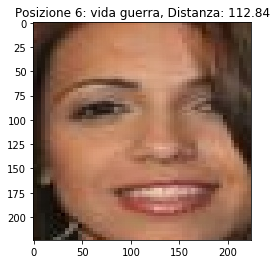

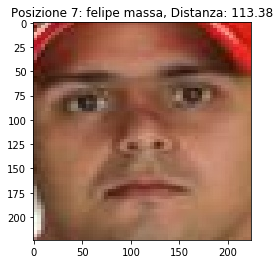

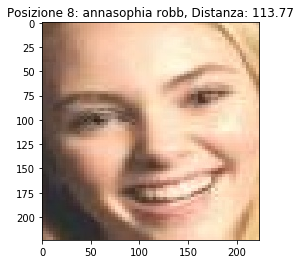

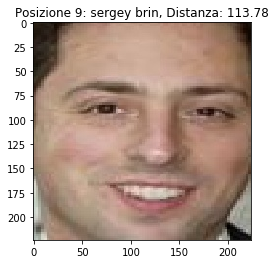

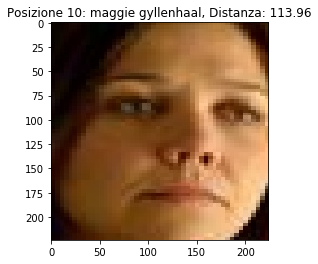

In [79]:
#FRA CON BALLTREE

# Ricerca
dist_fra_ball, ind_fra_ball = ball_tree.query(image_fra_features, k=10)

#print
for x in range(0,10):
    titolo = 'Posizione ' + str(x+1) + ': ' + str(paths[ind_fra_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distanza: ' + str(round(dist_fra_ball[0][x], 2)) 
    
    temp = kimage.load_img(paths[ind_fra_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(titolo)

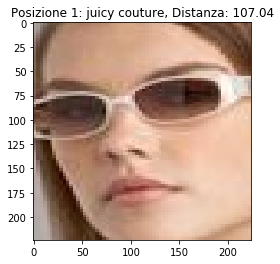

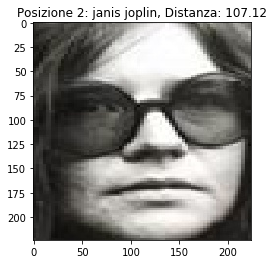

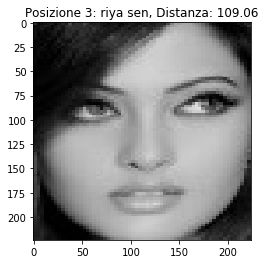

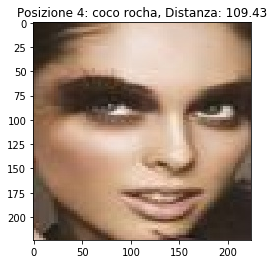

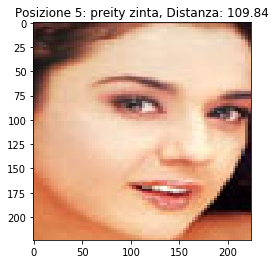

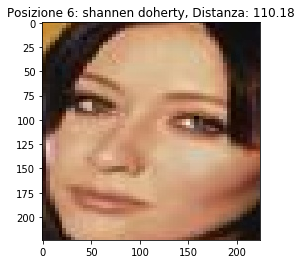

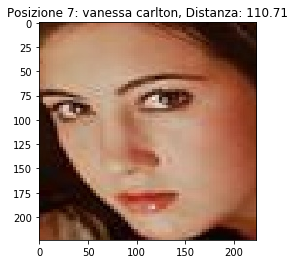

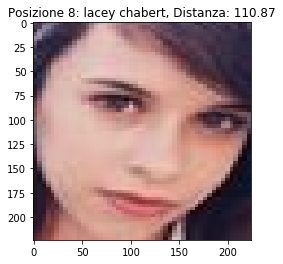

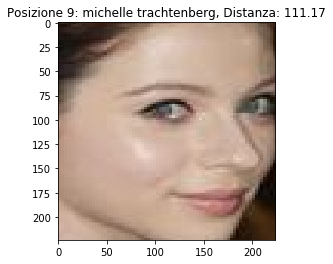

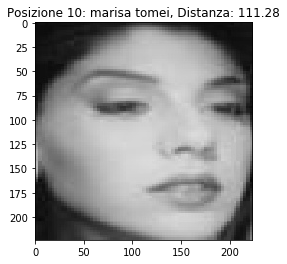

In [80]:
#CRI CON KDTREE

# Ricerca
dist_cri_kd, ind_cri_kd = kd_tree.query(image_cri_features, k=10)

# print
for x in range(0,10):
    titolo = 'Posizione ' + str(x+1) + ': ' + str(paths[ind_cri_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distanza: ' + str(round(dist_cri_kd[0][x], 2)) 
    
    temp = kimage.load_img(paths[ind_cri_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(titolo)

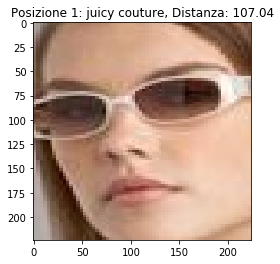

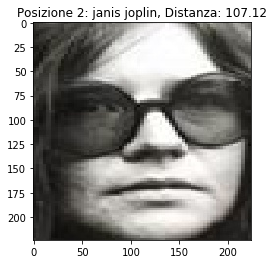

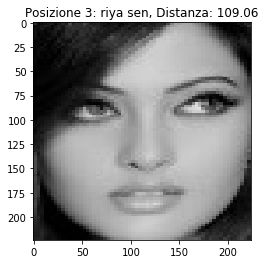

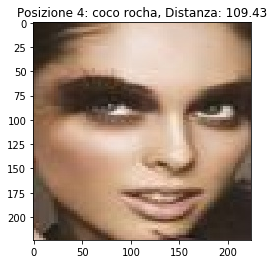

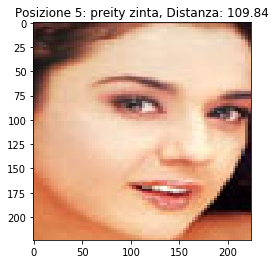

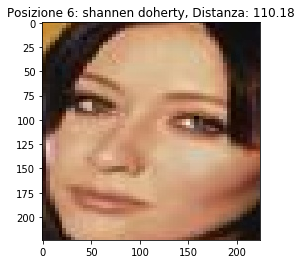

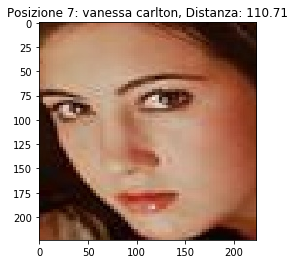

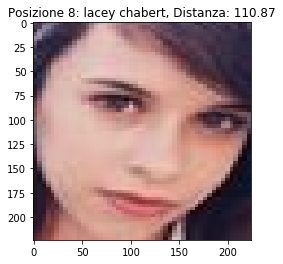

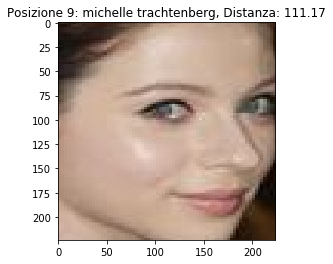

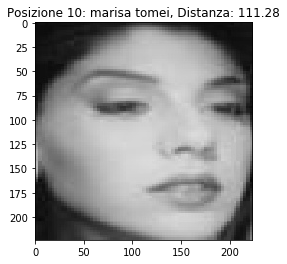

In [81]:
#CRI CON BALLTREE

# Ricerca
dist_cri_ball, ind_cri_ball = ball_tree.query(image_cri_features, k=10)

#print
for x in range(0,10):
    titolo = 'Posizione ' + str(x+1) + ': ' + str(paths[ind_cri_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distanza: ' + str(round(dist_cri_ball[0][x], 2)) 
    
    temp = kimage.load_img(paths[ind_cri_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(titolo)

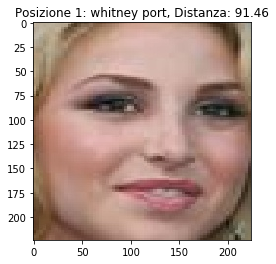

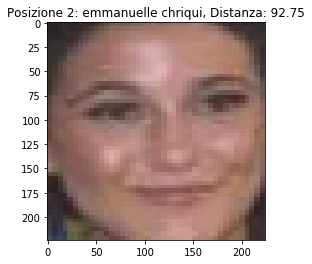

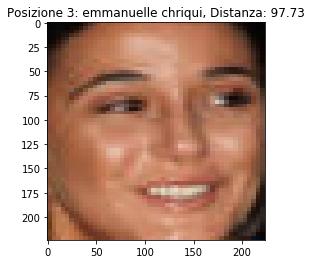

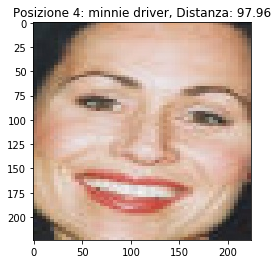

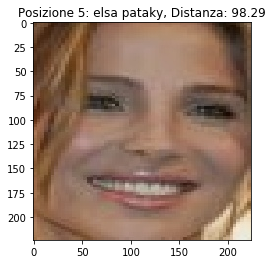

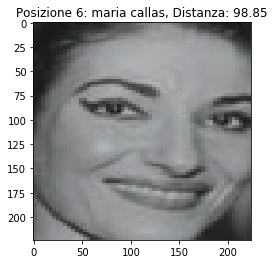

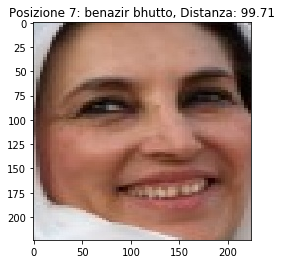

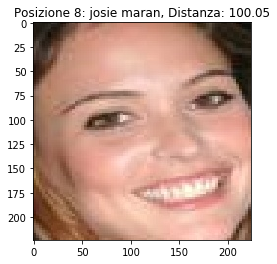

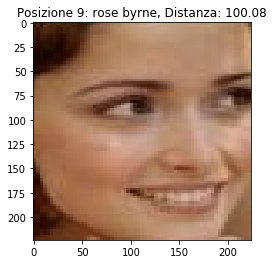

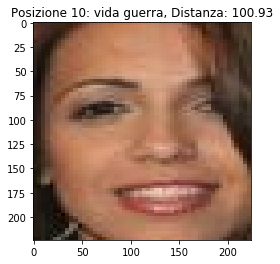

In [82]:
#ALE CON KDTREE

# Ricerca
dist_ale_kd, ind_ale_kd = kd_tree.query(image_ale_features, k=10)

# print
for x in range(0,10):
    titolo = 'Posizione ' + str(x+1) + ': ' + str(paths[ind_ale_kd[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distanza: ' + str(round(dist_ale_kd[0][x], 2)) 
    
    temp = kimage.load_img(paths[ind_ale_kd[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(titolo)

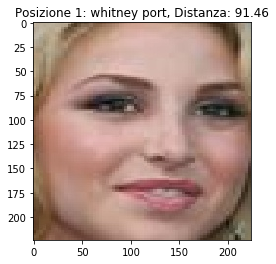

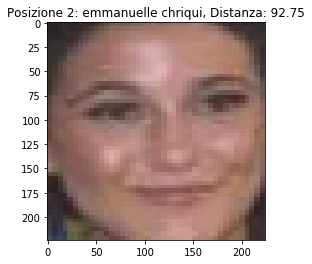

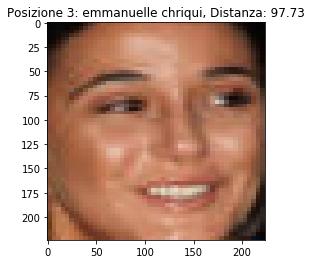

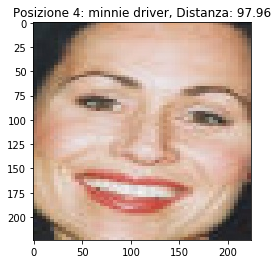

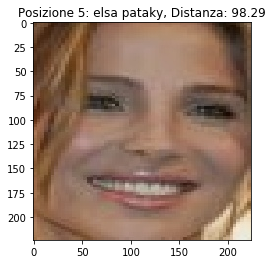

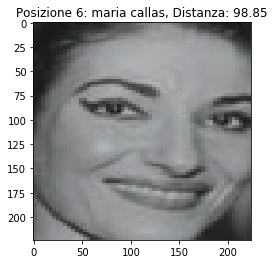

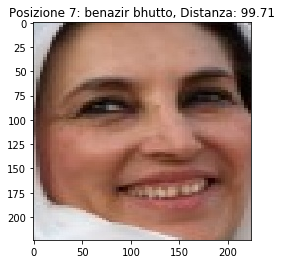

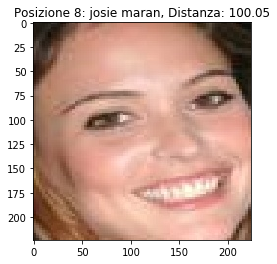

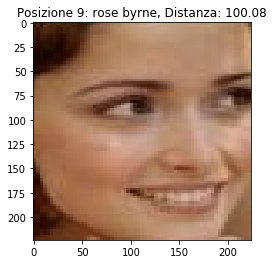

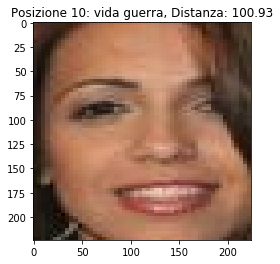

In [83]:
#ALE CON KDTREE

# Ricerca
dist_ale_ball, ind_ale_ball = ball_tree.query(image_ale_features, k=10)

#print
for x in range(0,10):
    titolo = 'Posizione ' + str(x+1) + ': ' + str(paths[ind_ale_ball[0][x]].split("/")[2].split(".")[0].split("_")[0]) + ', Distanza: ' + str(round(dist_ale_ball[0][x], 2)) 
    
    temp = kimage.load_img(paths[ind_ale_ball[0][x]])

    plt.figure()
    plt.imshow(temp)
    plt.title(titolo)